<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Order-of-faces-using-ISOMAP" data-toc-modified-id="1.-Order-of-faces-using-ISOMAP-1">1. Order of faces using ISOMAP</a></span><ul class="toc-item"><li><span><a href="#a.-Visualize-similarity-graph" data-toc-modified-id="a.-Visualize-similarity-graph-1.1">a. Visualize similarity graph</a></span></li><li><span><a href="#b.-Apply-ISOMAP-for-2-D-embedding" data-toc-modified-id="b.-Apply-ISOMAP-for-2-D-embedding-1.2">b. Apply ISOMAP for 2-D embedding</a></span></li><li><span><a href="#c.-Manhattan-distance" data-toc-modified-id="c.-Manhattan-distance-1.3">c. Manhattan distance</a></span></li></ul></li><li><span><a href="#2.-Density-estimation" data-toc-modified-id="2.-Density-estimation-2">2. Density estimation</a></span><ul class="toc-item"><li><span><a href="#a.-2-D-histograms" data-toc-modified-id="a.-2-D-histograms-2.1">a. 2-D histograms</a></span></li><li><span><a href="#b.-Kernel-density-estimation" data-toc-modified-id="b.-Kernel-density-estimation-2.2">b. Kernel density estimation</a></span></li><li><span><a href="#c.-Conditional-distribution-plots" data-toc-modified-id="c.-Conditional-distribution-plots-2.3">c. Conditional distribution plots</a></span></li></ul></li></ul></div>

# 1. Order of faces using ISOMAP

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.utils.graph import graph_shortest_path
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import radius_neighbors_graph
from scipy.io import loadmat
import networkx as nx

%matplotlib inline
np.random.seed(503)

In [2]:
# Load data and transpose
data = loadmat('isomap.mat')
print(f"Imported {data['images'].shape} array.")
images = data['images'].T

Imported (4096, 698) array.


In [3]:
num_images, num_pixels = images.shape
print(f"Images: {num_images}, pixels per image: {num_pixels}")

Images: 698, pixels per image: 4096


## a. Visualize similarity graph

In [4]:
def calculate_radius(images, metric='euclidean', min_neighbors=100):
    """Calculates the radius to use with radius_neighbors_graph in order to return a minimum number of neighbors."""    
    distances = pairwise_distances(images, metric=metric)
    distances.sort(axis=1)  # Sort each row of the distance matrix by its values
    # Take the x+1-ranked column of the sorted matrix and compute the greatest distance to find the minimum radius
    return distances[:, min_neighbors+1].max()

In [5]:
# Create adjacency matrix: identify neighbors with a distance lower than specified radius
radius = calculate_radius(images, metric='euclidean', min_neighbors=100)
print(f"Radius required: {radius}")

A_distances = radius_neighbors_graph(images, radius, mode='distance', metric='euclidean')

A_connectivity = (A_distances > 0).astype(float)  # Convert distances to 1 or 0
print(np.all(np.sum(A_connectivity, axis=1) >= 100))  # Check that each node has at least 100 neighbors

Radius required: 22.414735265879816
True


In [6]:
# Generate a networkx graph to help with visualization
A_graph = nx.convert_matrix.from_numpy_matrix(A_distances.toarray())
graph_positions = nx.spring_layout(A_graph, seed=503)

In [7]:
def plot_faces(images, positions, min_dist=0.025):
    """Plots faces evenly throughout the plot, ensuring no overlaps and sufficient distance between faces.
    :images: array of image pixels; each row represents one image.
    :positions: 2-D array (or dict) of relative positions for those images.    
    """
    ax = plt.gca()
    
    shown_images = np.array([[-10, -10]])  # Arbitrary position outside data range
    num_images, num_pixels = images.shape
    image_side_length = int(np.sqrt(num_pixels))
    
    for i in range(num_images):
        node_pos = positions[i]
        # Compute distance from current node to each other image already shown
        dist = np.sum((node_pos - shown_images) ** 2, axis=1)
        
        if np.min(dist) < min_dist:  # Don't plot if any other image is too close to the current node
            continue
        
        shown_images = np.vstack([shown_images, positions[i]])  # Add current image to the array of shown images
        
        image = images[i].reshape((image_side_length, image_side_length)).T
        ab = AnnotationBbox(OffsetImage(image, zoom=0.4, cmap='gray'), (node_pos[0], node_pos[1]), frameon=False)
        ax.add_artist(ab)

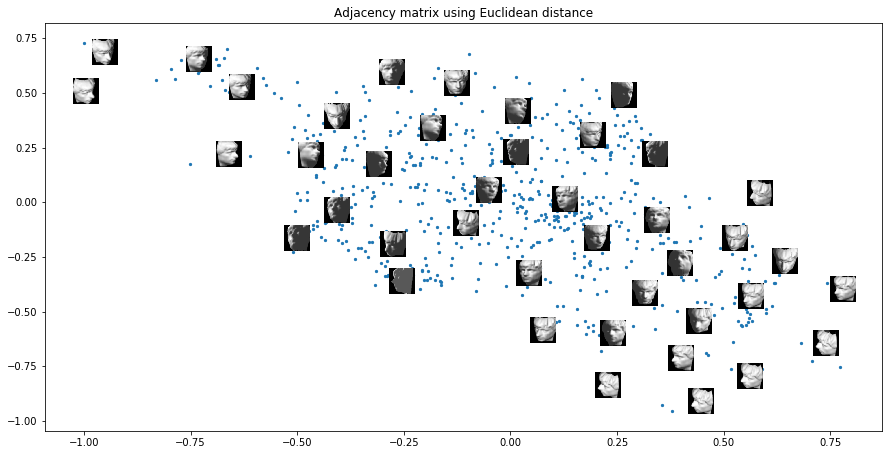

In [8]:
fig, ax = plt.subplots(figsize=(15, 7.5))

# Plot all points
for node in graph_positions.values():
    ax.scatter(node[0], node[1], c='#1f77b4', s=5)
        
# Plot faces
plot_faces(images, graph_positions, 0.025)    

ax.set_title("Adjacency matrix using Euclidean distance")
plt.show()

## b. Apply ISOMAP for 2-D embedding

In [9]:
# Compute pairwise shortest distance matrix D
D = graph_shortest_path(A_distances, directed=False)
print(f"D matrix:\n{D[:2, :]}")

D matrix:
[[ 0.         18.83094952  6.74323967 ... 21.51126745 28.50709299
  18.03618033]
 [18.83094952  0.         19.55307161 ... 15.07435566 21.63387369
  20.97399746]]


In [10]:
# Compute centering matrix H
m = D.shape[0]
I = np.identity(m)
H = I - 1/m * np.ones((m, m))
print(f"H matrix:\n{H[:2, :]}")

H matrix:
[[ 0.99856734 -0.00143266 -0.00143266 ... -0.00143266 -0.00143266
  -0.00143266]
 [-0.00143266  0.99856734 -0.00143266 ... -0.00143266 -0.00143266
  -0.00143266]]


In [11]:
# Compute centered distance matrix C
C = -1/(2*m) * H @ (D**2) @ H
print(f"Centered distance matrix C:\n{C[:2, :]}")

Centered distance matrix C:
[[ 0.12935747 -0.08468714  0.10981548 ... -0.05635786 -0.21257371
   0.01092581]
 [-0.08468714  0.20929784 -0.09151185 ...  0.15230748  0.074266
  -0.03119911]]


In [12]:
# Compute leading eigenpairs
eig_vals, eig_vecs = np.linalg.eig(C)

In [13]:
# Sort eigenpairs
eig_vecs = eig_vecs[:, np.argsort(-np.abs(eig_vals))]  # Sort eigenvectors by eigenvalues descending
eig_vals = eig_vals[np.argsort(-np.abs(eig_vals))]  # Sort eigenvalues

In [14]:
# Compute 2-D embedding: take top 2 principal components, scaled by the square root of the eigenvalue
Z_T = eig_vecs[:, :2] * eig_vals[:2]**(1/2)

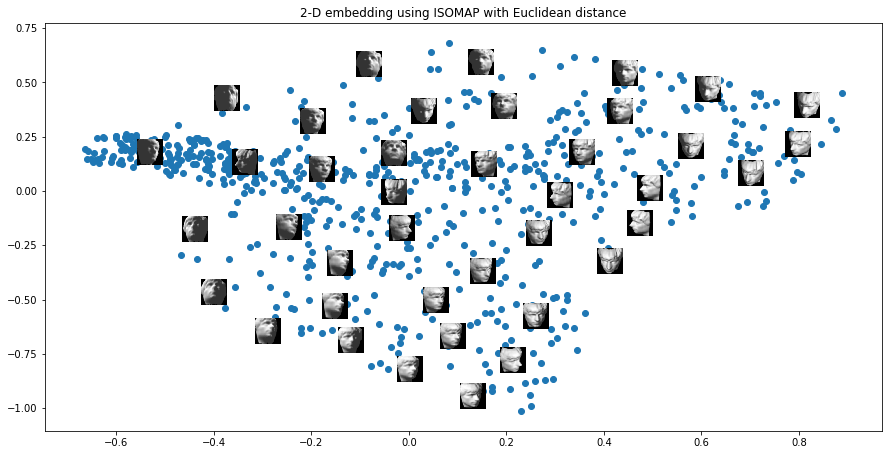

In [15]:
fig, ax = plt.subplots(figsize=(15, 7.5))

# Plot all points in the 2-D embedding
ax.scatter(Z_T[:, 0], Z_T[:, 1])
        
# Plot faces
plot_faces(images, Z_T, 0.025)
ax.set_title("2-D embedding using ISOMAP with Euclidean distance")

plt.show()

ISOMAP appears to do a better job of placing similar faces near each other.

## c. Manhattan distance

In [16]:
# Create adjacency matrix: identify neighbors with a distance lower than specified radius
radius = calculate_radius(images, metric='manhattan', min_neighbors=100)
print(f"Radius required: {radius}")

A_distances = radius_neighbors_graph(images, radius, mode='distance', metric='manhattan')

A_connectivity = (A_distances > 0).astype(float)  # Convert distances to 1 or 0
print(np.all(np.sum(A_connectivity, axis=1) >= 100))  # Check that each node has at least 100 neighbors

Radius required: 1011.0060661764716
True


In [17]:
# Generate a networkx graph to help with visualization
A_graph = nx.convert_matrix.from_numpy_matrix(A_distances.toarray())
graph_positions = nx.spring_layout(A_graph, seed=503)

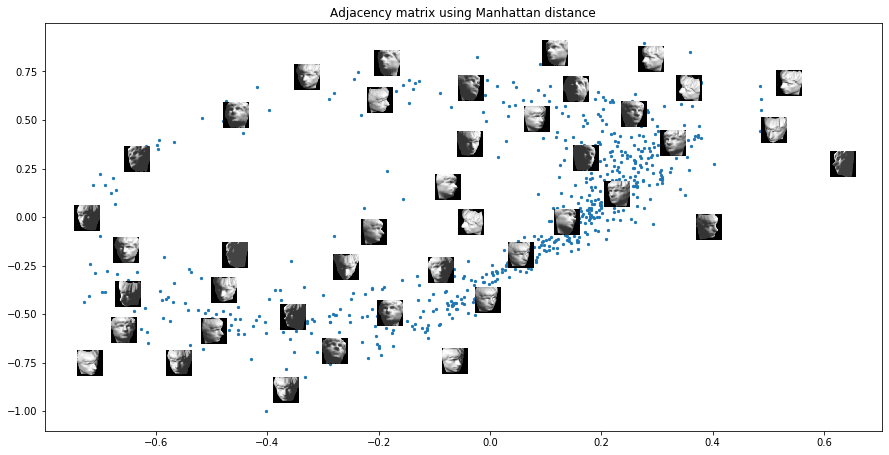

In [18]:
fig, ax = plt.subplots(figsize=(15, 7.5))

# Plot all points
for node in graph_positions.values():
    ax.scatter(node[0], node[1], c='#1f77b4', s=5)
        
# Plot faces
plot_faces(images, graph_positions, 0.025)    

ax.set_title("Adjacency matrix using Manhattan distance")
plt.show()

In [19]:
# Compute pairwise shortest distance matrix D
D = graph_shortest_path(A_distances, directed=False)
print(f"D matrix:\n{D[:2, :]}")

D matrix:
[[   0.          965.31026348  257.36994485 ... 1180.2359375
  1333.1890625   801.11789216]
 [ 965.31026348    0.          998.80539216 ...  591.33363971
  1219.31158088 1257.4520527 ]]


In [20]:
# Compute centering matrix H
m = D.shape[0]
I = np.identity(m)
H = I - 1/m * np.ones((m, m))
print(f"H matrix:\n{H[:2, :]}")

H matrix:
[[ 0.99856734 -0.00143266 -0.00143266 ... -0.00143266 -0.00143266
  -0.00143266]
 [-0.00143266  0.99856734 -0.00143266 ... -0.00143266 -0.00143266
  -0.00143266]]


In [21]:
# Compute centered distance matrix C
C = -1/(2*m) * H @ (D**2) @ H
print(f"Centered distance matrix C:\n{C[:2, :]}")

Centered distance matrix C:
[[ 396.81521232 -188.68638009  375.81071273 ... -405.43135667
  -450.13105201  128.62050891]
 [-188.68638009  560.80329509 -209.36782675 ...  423.89892735
  -159.91899838 -462.3050684 ]]


In [22]:
# Compute leading eigenpairs
eig_vals, eig_vecs = np.linalg.eig(C)

In [23]:
# Sort eigenpairs
eig_vecs = eig_vecs[:, np.argsort(-np.abs(eig_vals))]  # Sort eigenvectors by eigenvalues descending
eig_vals = eig_vals[np.argsort(-np.abs(eig_vals))]  # Sort eigenvalues

In [24]:
# Compute 2-D embedding: take top 2 principal components, scaled by the square root of the eigenvalue
Z_T = eig_vecs[:, :2] * eig_vals[:2]**(1/2)

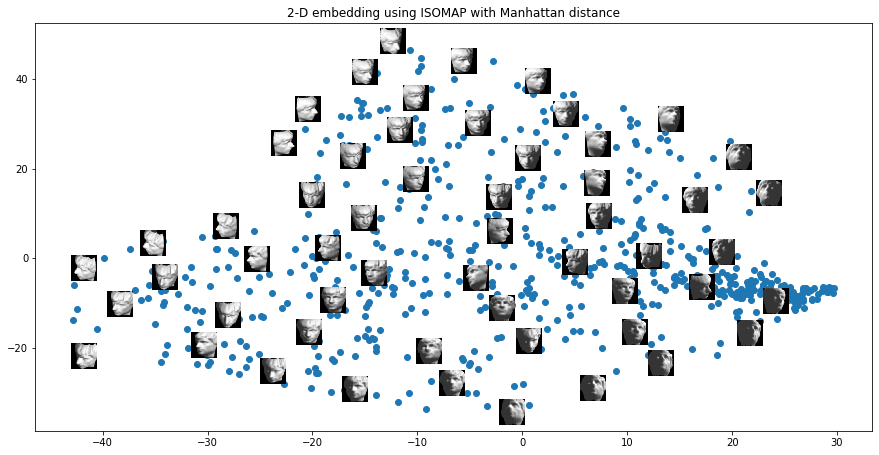

In [25]:
fig, ax = plt.subplots(figsize=(15, 7.5))

# Plot all points in the 2-D embedding
ax.scatter(Z_T[:, 0], Z_T[:, 1])
        
# Plot faces
plot_faces(images, Z_T, 50)
ax.set_title("2-D embedding using ISOMAP with Manhattan distance")

plt.show()

The image above also shows that points near each other are roughly facing the same direction.

# 2. Density estimation

In [26]:
# Additional imports
import pandas as pd
from sklearn import preprocessing
from math import pi
from mpl_toolkits.mplot3d import Axes3D

In [27]:
# Read data
data = pd.read_csv('n90pol.csv')
display(data.head())

,amygdala,acc,orientation
0,0.0051,-0.0286,2
1,-0.0674,0.0007,3
2,-0.0257,-0.0110,3
3,0.0504,-0.0167,2
4,0.0125,-0.0005,5


In [28]:
# Create NumPy arrays
X = data.iloc[:, :2].values
y = data.iloc[:, 2].values

## a. 2-D histograms

In [29]:
data.describe()

,amygdala,acc,orientation
count,90.000000,90.000000,90.000000
mean,0.000001,-0.000006,3.577778
std,0.032605,0.020435,0.899160
min,-0.067600,-0.037700,2.000000
25%,-0.020150,-0.012200,3.000000
50%,-0.000700,-0.003950,4.000000
75%,0.024775,0.011650,4.000000
max,0.081200,0.055900,5.000000


In [30]:
# amygdala and acc have different ranges, so scale them
X_scaled = preprocessing.scale(X)

In [31]:
# Column-wise minimum/maximum values
minima = X_scaled.min(0)
maxima = X_scaled.max(0)

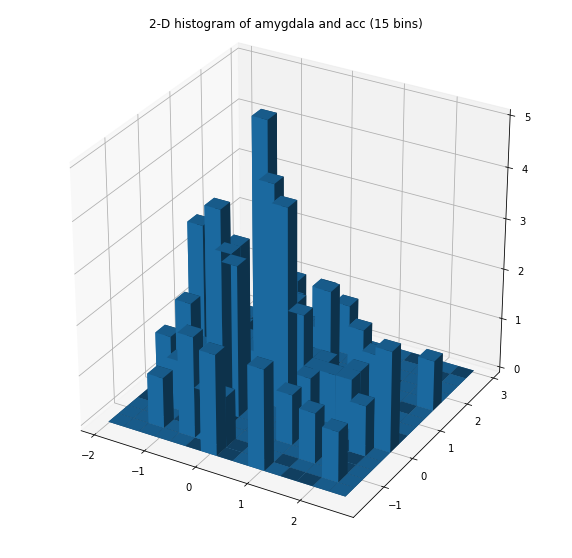

In [32]:
num_bins = 15  # Set through trial and error

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

hist, x_edges, y_edges = np.histogram2d(X_scaled[:, 0], X_scaled[:, 1], bins=num_bins)
x_pos, y_pos = np.meshgrid(x_edges[:-1] + x_edges[1:], y_edges[:-1] + y_edges[1:])
x_pos = x_pos.flatten() / 2.
y_pos = y_pos.flatten() / 2.
z_pos = np.zeros_like(x_pos)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dz = hist.flatten()

ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz)
ax.set_title(f"2-D histogram of amygdala and acc ({num_bins} bins)").set_position((0.5, 0.95))

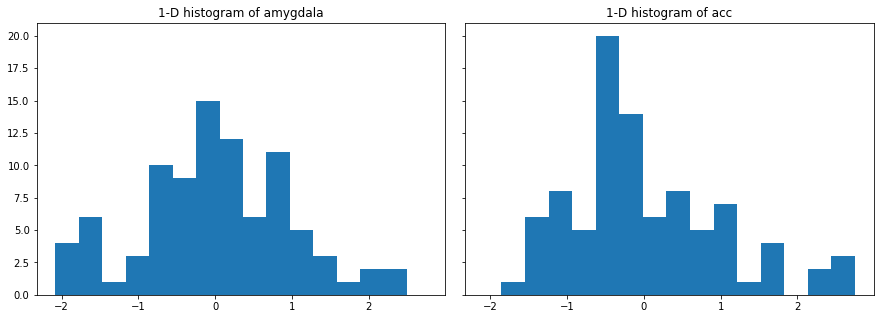

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0.05)

for i in range(2):
    ax[i].hist(X_scaled[:, i], bins=num_bins)
    ax[i].set_title(f"1-D histogram of {data.columns[i]}")

## b. Kernel density estimation

In [34]:
# Define grid points (meshgrid)
m, n = X_scaled.shape
grid_cells = 250
inc_0 = (maxima[0] - minima[0]) / grid_cells
inc_1 = (maxima[1] - minima[1]) / grid_cells

# Form a grid of points for which we will calculate and plot density
grid_x, grid_y = np.meshgrid(
    np.arange(minima[0], maxima[0] + inc_0, inc_0),
    np.arange(minima[1], maxima[1] + inc_1, inc_1),
)

# Combine grid points into coordinate pairs (tall array with 2 columns)
grid_points = np.asarray([grid_x.flatten(order='F'), grid_y.flatten(order='F')]).T

num_grid_points, num_cols = grid_points.shape

In [35]:
grid_y.shape

(251, 251)

In order to calculate distance, I use this identity of Euclidean distance:

$$
\lVert q - p \rVert = \sqrt{\lVert p \rVert^2 + \lVert q \rVert^2 - 2p \cdot q}
$$

I will need the squared distance $(x_i - \mu)^2$, which can be calculated as $\lVert q - p \rVert^2 = \lVert p \rVert^2 + \lVert q \rVert^2 - 2p \cdot q$.

In [36]:
# Calculate the squared distance of every point in the grid from every actual data point
X_norms_sq = (X_scaled**2).sum(axis=1)  # Squared norms of data points: ||q||^2
grid_points_norm_sq = (grid_points**2).sum(axis=1)  # Squared norms of grid points: ||p||^2
cross = X_scaled.dot(grid_points.T)  # Final term under the root: 2p dot q

distance_sq = (np.repeat(X_norms_sq, repeats=num_grid_points)
                 .reshape(m, num_grid_points)  # Reshape: 1 row per data point, 1 col per grid point
                 + np.tile(grid_points_norm_sq, m)  # Add q and p squared norms for every data point/grid point combo
                     .reshape(m, num_grid_points)
                 - (2 * cross))  # Subtract that last time

In [37]:
# Pass this distance into the gaussian PDF
bandwidth = 1

kernel_values = 1 / np.sqrt(2 * pi * bandwidth**2) * np.exp(-distance_sq / (2 * bandwidth**2))

In [38]:
# Return the total density for every point in the grid
densities = sum(kernel_values) / m

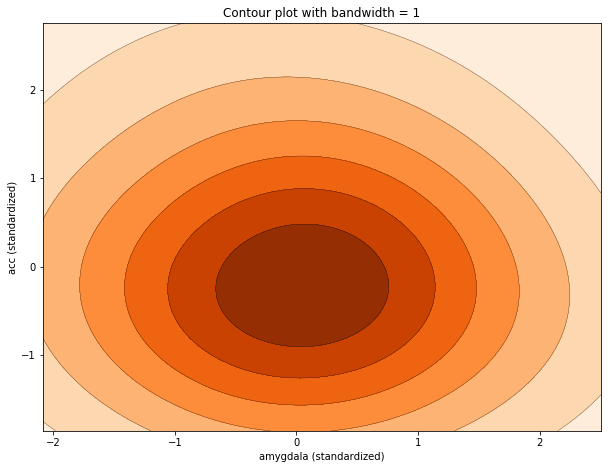

In [39]:
# Reshape the densities array into grid dimensions
densities = (densities.T).reshape(grid_cells + 1, grid_cells + 1).T

# Plot the grid point densities
fig = plt.figure(figsize=(10, 7.5))
ax = fig.gca()
ax.set_xlim(minima[0], maxima[0])
ax.set_ylim(minima[1], maxima[1])

contourfs = ax.contourf(grid_x, grid_y, densities, cmap='Oranges')
contours = ax.contour(grid_x, grid_y, densities, colors='k', linewidths=0.25)

ax.set_xlabel("amygdala (standardized)")
ax.set_ylabel("acc (standardized)")
ax.set_title(f"Contour plot with bandwidth = {bandwidth}")
plt.show()

The graph above does not show the shape of the data very well. Below, I wrap up the previous code into a function and call it for various bandwidth values.

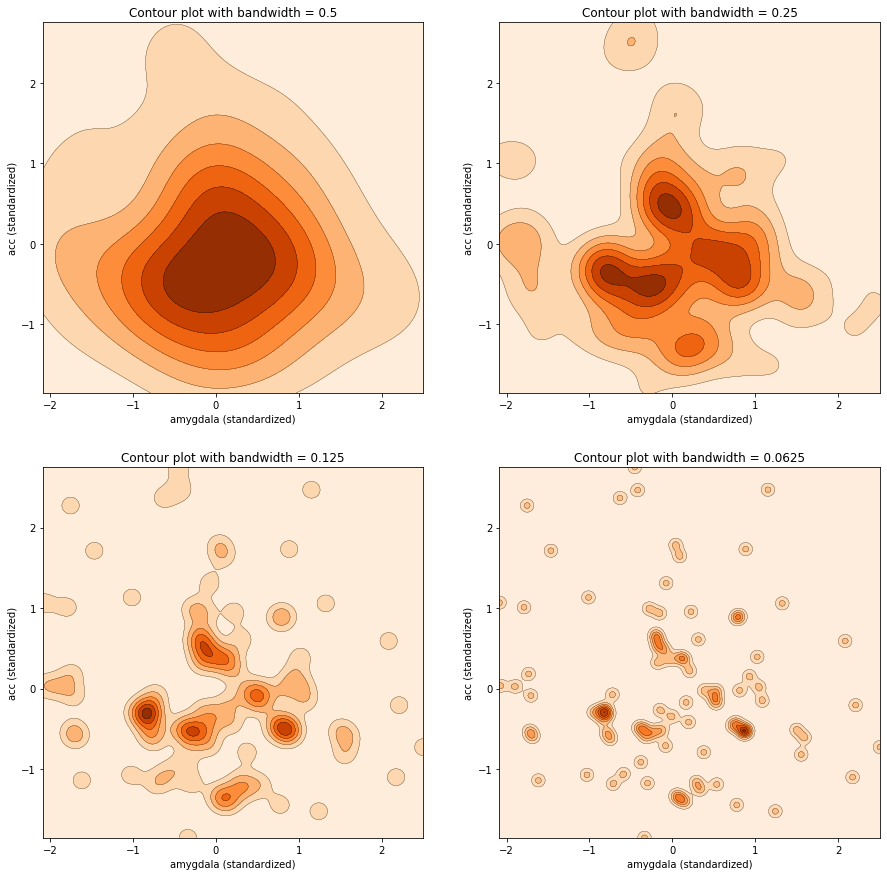

In [40]:
# Experiment with different values of bandwidth
def gaussian_kde(squared_distances, bandwidth, grid_cells):
    """Calculates densities for a grid."""
    # Compute KDE
    kernel_values = 1 / np.sqrt(2 * pi * bandwidth**2) * np.exp(-squared_distances / (2 * bandwidth**2))
    densities = sum(kernel_values) / m
    densities = (densities.T).reshape(grid_cells + 1, grid_cells + 1).T
    return densities
    
# Draw the contour plots
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
bandwidth = 1  # Start with prior bandwidth

for i in range(2):    
    for j in range(2):
        # Halve bandwidth, recompute densities, and plot
        bandwidth = bandwidth / 2
        densities = gaussian_kde(distance_sq, bandwidth, grid_cells)
        
        ax[i][j].set_xlim(minima[0], maxima[0])
        ax[i][j].set_ylim(minima[1], maxima[1])

        contourfs = ax[i][j].contourf(grid_x, grid_y, densities, cmap='Oranges')
        contours = ax[i][j].contour(grid_x, grid_y, densities, colors='k', linewidths=0.25)

        ax[i][j].set_xlabel("amygdala (standardized)")
        ax[i][j].set_ylabel("acc (standardized)")
        ax[i][j].set_title(f"Contour plot with bandwidth = {bandwidth}")

plt.show()

In [45]:
# Silverman's rule: h = 1.06 * sigma * m^(-1/5)

1.06 * np.std(X_scaled) * 90**(-1/5)

0.4309802446783169

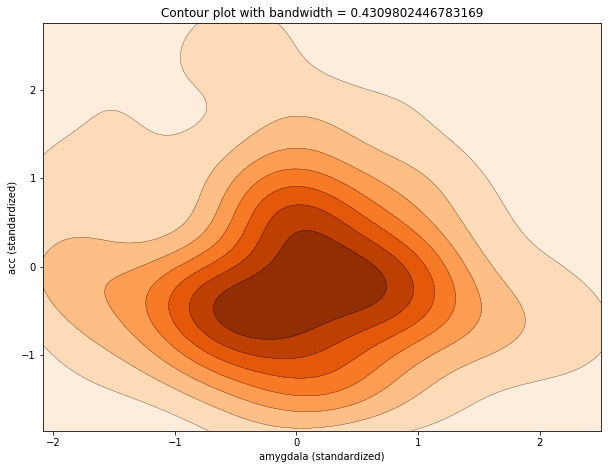

In [46]:
fig, ax = plt.subplots(figsize=(10, 7.5))
bandwidth = 1  # Start with prior bandwidth

# Halve bandwidth, recompute densities, and plot
bandwidth = 1.06 * np.std(X_scaled) * m**(-1/5)
densities = gaussian_kde(distance_sq, bandwidth, grid_cells)

contourfs = ax.contourf(grid_x, grid_y, densities, cmap='Oranges')
contours = ax.contour(grid_x, grid_y, densities, colors='k', linewidths=0.25)

ax.set_xlabel("amygdala (standardized)")
ax.set_ylabel("acc (standardized)")
ax.set_title(f"Contour plot with bandwidth = {bandwidth}")

plt.show()

## c. Conditional distribution plots

In [42]:
# Imports
import seaborn as sb

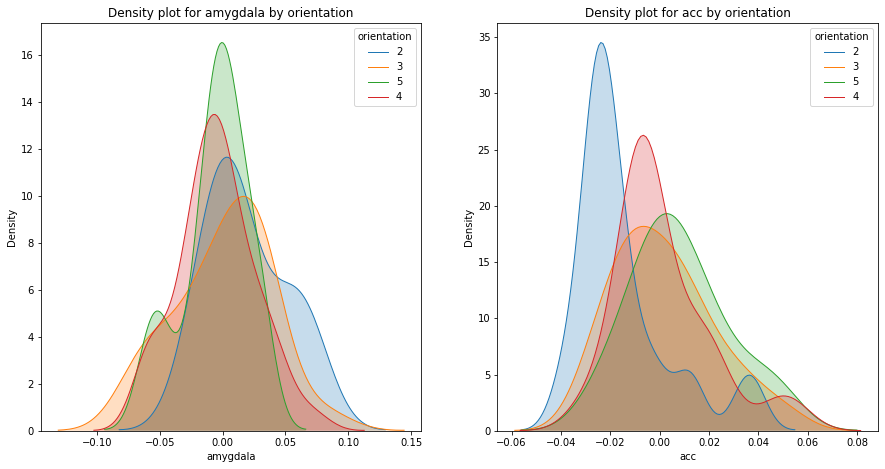

In [43]:
# List of political orientations
orientations = data['orientation'].unique().tolist()
var_names = ['amygdala', 'acc']

fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))

for i, var_name in enumerate(var_names):
    for orientation in orientations:
        subset = data.loc[data['orientation'] == orientation, :]

        sb.distplot(subset[var_name], hist=False, kde=True,
                    kde_kws={'linewidth': 1, 'shade': True},
                    label=orientation, ax=ax[i])
        
        ax[i].legend(title="orientation")
        ax[i].set_title(f"Density plot for {var_name} by orientation")
        ax[i].set_ylabel("Density")